# Example Track Corridor

This is an example of calculating the track corridor for a satellite with a certain angular visibility. The example is a translated and modified version of the orekit java tutorial "Track Corridor" that is part of the orekit source code. Translated and modified by Petrus Hyvönen, SSC.

Set up the ipython notebook:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


Initilize orekit and the java virtual machine

In [2]:
import orekit_jpype as orekit
orekit.initVM()

Setup the orekit data loading, the file orekit-data.zip shall be in same directory as notebook.

In [3]:
from jpype import JImplements, JOverride

In [4]:
from orekit_jpype.pyhelpers import setup_orekit_data
setup_orekit_data()

In [5]:
from org.orekit.time import TimeScalesFactory
from org.orekit.time import AbsoluteDate
from org.orekit.utils import Constants
from org.orekit.propagation.analytical.tle import TLE
from org.orekit.propagation.analytical.tle import TLEPropagator
from org.hipparchus.geometry.euclidean.threed import Line
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.bodies import OneAxisEllipsoid
from org.orekit.frames import FramesFactory
from org.orekit.utils import IERSConventions
from org.orekit.propagation.sampling import OrekitFixedStepHandler


In [6]:
import math
from IPython.display import FileLink, display


In [7]:
utc = TimeScalesFactory.getUTC()

TLE is used for the orbit description

In [8]:
TLE_LINE1 = "1 27421U 02021A   02124.48976499 -.00021470  00000-0 -89879-2 0    20"
TLE_LINE2 = "2 27421  98.7490 199.5121 0001333 133.9522 226.1918 14.26113993    62"

Simulation parameters

In [9]:
DURATION = 1.0 * 60 * 180
STEP = 10.0
ANGULAR_OFFSET = 35 # Sensor half width

Set up the tle propagator

In [10]:
TimeScalesFactory

<java class 'org.orekit.time.TimeScalesFactory'>

In [11]:
tle = TLE(TLE_LINE1, TLE_LINE2)

propagator = TLEPropagator.selectExtrapolator(tle)
start = tle.getDate()   

Create a custom step handler that for each step stores the corridor information. As we are subclassing an orekit object in Python and want the java code to access the python code, we need to use the version of the class that includes Python specific code.

In [12]:
@JImplements(OrekitFixedStepHandler)
class CorridorHandler():
    
    def __init__(self, angle):
            # set up Earth model
            self.earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                                         Constants.WGS84_EARTH_FLATTENING,
                                         FramesFactory.getITRF(IERSConventions.IERS_2010, False))
            
            # set up position offsets, using Earth radius as an arbitrary distance
            self.deltaR = Constants.WGS84_EARTH_EQUATORIAL_RADIUS * math.cos(math.radians(angle))
            self.deltaC = Constants.WGS84_EARTH_EQUATORIAL_RADIUS * math.sin(math.radians(angle))

            # prepare an empty corridor
            self.dates = []
            self.lefts = []
            self.centers = []
            self.rights = []
    
    @JOverride  
    def init(self, s0, t, step):
        # needs to be stated to fulfill the interface specification
        pass

    @JOverride  
    def handleStep(self, currentState):
        # compute sub-satellite track
        date    = currentState.getDate()
        pvInert = currentState.getPVCoordinates()
        t       = currentState.getFrame().getTransformTo(self.earth.getBodyFrame(), date)
        p       = t.transformPosition(pvInert.getPosition())
        v       = t.transformVector(pvInert.getVelocity())
        center  = self.earth.transform(p, self.earth.getBodyFrame(), date)
        
        # compute left and right corridor points
        nadir      = p.normalize().negate()
        crossTrack = p.crossProduct(v).normalize()
        leftLine   = Line(p, Vector3D(1.0, p, self.deltaR, nadir,  self.deltaC, crossTrack), 1.0)
        left       = self.earth.getIntersectionPoint(leftLine, p, self.earth.getBodyFrame(), date)
        rightLine  = Line(p, Vector3D(1.0, p, self.deltaR, nadir, -self.deltaC, crossTrack), 1.0)
        right      = self.earth.getIntersectionPoint(rightLine, p, self.earth.getBodyFrame(), date)
        

        # add the corridor points
        self.dates.append(date)
        self.lefts.append(left)
        self.centers.append(center)
        self.rights.append(right)
        
    @JOverride
    def finish(self, s):
        pass
        

Create the handler and associate it with the propagator.

In [13]:
handler = CorridorHandler(ANGULAR_OFFSET)
propagator.setStepHandler(STEP, handler)

Perform the propagation where our custom step handler creates the corridor vectors.

In [14]:
propagator.propagate(start, start.shiftedBy(DURATION));

Create a function to extract latitude and longitude as python lists suitable for plotting

In [15]:
def geoline(geopoints):
    lon = [math.degrees(x.getLongitude()) for x in geopoints]
    lat = [math.degrees(x.getLatitude()) for x in geopoints]
    return lon, lat

Another library for mapping is cartopy, which has a real geodetic plotting, avoiding errornous lines at map borders.

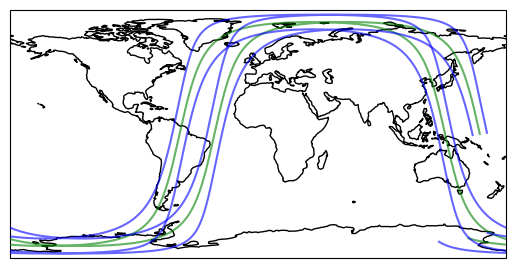

In [16]:
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

lon, lat = geoline(handler.centers)
ax.plot(lon, lat, transform=ccrs.Geodetic(), alpha=0.6, color='green', zorder=3);

lon, lat = geoline(handler.lefts)
ax.plot(lon, lat, transform=ccrs.Geodetic(), alpha=0.6, color='blue', zorder=3);

lon, lat = geoline(handler.rights)
ax.plot(lon, lat, transform=ccrs.Geodetic(), alpha=0.6, color='blue', zorder=3);


Different projections makes it more readable

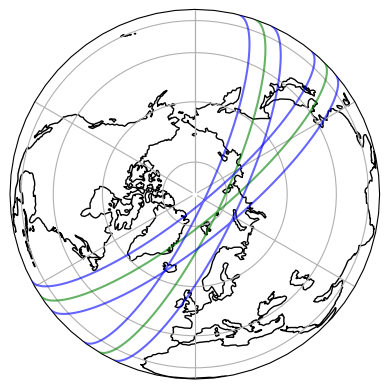

In [17]:
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0, globe=None))
ax.coastlines()

ax.set_global()

ax.gridlines()
lon, lat = geoline(handler.centers)
ax.plot(lon, lat, transform=ccrs.Geodetic(), alpha=0.6, color='green', zorder=3);

lon, lat = geoline(handler.lefts)
ax.plot(lon, lat, transform=ccrs.Geodetic(), alpha=0.6, color='blue', zorder=3);

lon, lat = geoline(handler.rights)
ax.plot(lon, lat, transform=ccrs.Geodetic(), alpha=0.6, color='blue', zorder=3);
